In [1]:
import pandas as pd
df = pd.read_csv('singapore_2024_race_laps.csv')
df


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:58:41.675000,NOR,4,0 days 00:01:40.424000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:41.379000,...,True,McLaren,0 days 00:57:01.006000,2024-09-22 12:03:57.137,1,1.0,False,NaN,False,False
1,0 days 01:00:20.155000,NOR,4,0 days 00:01:38.480000,2.0,1.0,NaN,NaN,0 days 00:00:29.268000,0 days 00:00:41.412000,...,True,McLaren,0 days 00:58:41.675000,2024-09-22 12:05:37.806,1,1.0,False,NaN,False,True
2,0 days 01:01:58.561000,NOR,4,0 days 00:01:38.406000,3.0,1.0,NaN,NaN,0 days 00:00:29.354000,0 days 00:00:41.262000,...,True,McLaren,0 days 01:00:20.155000,2024-09-22 12:07:16.286,1,1.0,False,NaN,False,True
3,0 days 01:03:37.007000,NOR,4,0 days 00:01:38.446000,4.0,1.0,NaN,NaN,0 days 00:00:29.399000,0 days 00:00:41.305000,...,True,McLaren,0 days 01:01:58.561000,2024-09-22 12:08:54.692,1,1.0,False,NaN,False,True
4,0 days 01:05:14.945000,NOR,4,0 days 00:01:37.938000,5.0,1.0,NaN,NaN,0 days 00:00:29.034000,0 days 00:00:41.159000,...,True,McLaren,0 days 01:03:37.007000,2024-09-22 12:10:33.138,1,1.0,False,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,0 days 01:15:35.022000,ALB,23,0 days 00:01:46.666000,11.0,1.0,NaN,0 days 01:15:27.422000,0 days 00:00:29.101000,0 days 00:00:42.374000,...,True,Williams,0 days 01:13:48.356000,2024-09-22 12:20:44.487,1,17.0,False,NaN,False,False
1173,0 days 01:17:33.048000,ALB,23,0 days 00:01:58.026000,12.0,2.0,0 days 01:15:56.538000,NaN,0 days 00:00:49.705000,0 days 00:00:40.831000,...,True,Williams,0 days 01:15:35.022000,2024-09-22 12:22:31.153,1,19.0,False,NaN,False,False
1174,0 days 01:19:09.936000,ALB,23,0 days 00:01:36.888000,13.0,2.0,NaN,NaN,0 days 00:00:28.928000,0 days 00:00:40.666000,...,True,Williams,0 days 01:17:33.048000,2024-09-22 12:24:29.179,1,19.0,False,NaN,False,True
1175,0 days 01:20:48.676000,ALB,23,0 days 00:01:38.740000,14.0,2.0,NaN,NaN,0 days 00:00:29.358000,0 days 00:00:41.648000,...,True,Williams,0 days 01:19:09.936000,2024-09-22 12:26:06.067,1,19.0,False,NaN,False,True


In [2]:
df['LapTime'] = pd.to_timedelta(df['LapTime'], errors='coerce')
df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()

In [3]:
voltas_completadas = df.groupby('Driver')['LapNumber'].max()
num_voltas_corrida = 62  # exemplo para Abu Dhabi 2024
limite_conclusao = 0.9 * num_voltas_corrida

concluiu = voltas_completadas >= limite_conclusao

df_features = pd.DataFrame({
    'Driver': voltas_completadas.index,
    'VoltasCompletadasDadosBrutos': voltas_completadas.values,
    'Concluiu': concluiu.values
})

# Resetar o índice para manter um DataFrame limpo
df_features.reset_index(drop=True, inplace=True)

In [4]:
import pandas as pd
import numpy as np

# 1. Criar pits_df com voltas que tem PitInTime ou PitOutTime (opcional, só para pegar dados importantes)
pits_df = df[df['PitInTime'].notna() | df['PitOutTime'].notna()]
pits_df = pits_df[['Driver', 'LapNumber', 'PitInTime', 'PitOutTime', 'Compound', 'TyreLife', 'Stint']]
pits_df = pits_df.sort_values(['Driver', 'LapNumber']).reset_index(drop=True)

# 2. Número de paradas no box por piloto = número de stints - 1
num_stints = df.groupby('Driver')['Stint'].nunique()
pit_counts = (num_stints - 1).rename('NumParadasBox')

# 3. Volta do primeiro pit stop por piloto — pegar a menor volta onde mudou o stint (ou a primeira volta do segundo stint)
# Para isso, pegar a volta mínima para cada piloto onde o stint é > 1
primeiro_pit = df[df['Stint'] > 1].groupby('Driver')['LapNumber'].min().rename('VoltaPrimeiroPit')

# 4. Duração média dos stints por piloto (número médio de voltas por stint)
stint_dur = df.groupby(['Driver', 'Stint']).size().groupby('Driver').mean().rename('DuracaoMediaStint')

# 5. Proporção de voltas por tipo de pneu
voltas_totais = df.groupby('Driver').size()

prop_soft = df[df['Compound'] == 'SOFT'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMacios')
prop_medium = df[df['Compound'] == 'MEDIUM'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMedios')
prop_hard = df[df['Compound'] == 'HARD'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasDuros')

# 6. Juntar tudo num DataFrame
df_pit_features = pd.concat([
    pit_counts,
    primeiro_pit,
    stint_dur,
    prop_soft,
    prop_medium,
    prop_hard
], axis=1).reset_index()

# Substituir NaNs por 0 para pilotos sem dados em algumas colunas
df_pit_features.fillna({
    'NumParadasBox': 0,
    'VoltaPrimeiroPit': 0,
    'DuracaoMediaStint': 0,
    'PropVoltasMacios': 0,
    'PropVoltasMedios': 0,
    'PropVoltasDuros': 0
}, inplace=True)

print(df_pit_features.head())


  Driver  NumParadasBox  VoltaPrimeiroPit  DuracaoMediaStint  \
0    ALB              1              12.0                7.5   
1    ALO              1              26.0               30.5   
2    BOT              1              34.0               30.5   
3    COL              1              30.0               30.5   
4    GAS              1              38.0               30.5   

   PropVoltasMacios  PropVoltasMedios  PropVoltasDuros  
0          0.000000          0.733333         0.266667  
1          0.000000          0.409836         0.590164  
2          0.000000          0.459016         0.540984  
3          0.000000          0.475410         0.524590  
4          0.393443          0.606557         0.000000  


In [5]:
pits_df

,Driver,LapNumber,PitInTime,PitOutTime,Compound,TyreLife,Stint
0,ALB,11.0,0 days 01:15:27.422000,NaN,MEDIUM,11.0,1.0
1,ALB,12.0,NaN,0 days 01:15:56.538000,HARD,1.0,2.0
2,ALB,15.0,0 days 01:22:54.323000,NaN,HARD,4.0,2.0
3,ALO,25.0,0 days 01:38:25.721000,NaN,MEDIUM,26.0,1.0
4,ALO,26.0,NaN,0 days 01:38:55.403000,HARD,2.0,2.0
5,BOT,33.0,0 days 01:52:26.916000,NaN,HARD,33.0,1.0
6,BOT,34.0,NaN,0 days 01:52:57.527000,MEDIUM,1.0,2.0
7,COL,29.0,0 days 01:45:06.643000,NaN,MEDIUM,29.0,1.0
8,COL,30.0,NaN,0 days 01:45:36.597000,HARD,1.0,2.0
9,GAS,37.0,0 days 01:59:08.929000,NaN,MEDIUM,37.0,1.0


In [6]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,1,12.0,7.50,0.000000,0.733333,0.266667
1,ALO,1,26.0,30.50,0.000000,0.409836,0.590164
2,BOT,1,34.0,30.50,0.000000,0.459016,0.540984
3,COL,1,30.0,30.50,0.000000,0.475410,0.524590
4,GAS,1,38.0,30.50,0.393443,0.606557,0.000000
5,HAM,1,18.0,31.00,0.274194,0.000000,0.725806
6,HUL,1,30.0,30.50,0.000000,0.475410,0.524590
7,LEC,1,37.0,31.00,0.000000,0.580645,0.419355
8,MAG,2,29.0,19.00,0.140351,0.368421,0.491228
9,NOR,1,31.0,31.00,0.000000,0.483871,0.516129


In [7]:
df = df[df['IsAccurate']]


In [8]:
df['IsAccurate'].value_counts()


,count
IsAccurate,
True,1109


In [9]:
df['Driver'].value_counts()


,count
Driver,
NOR,59
VER,59
PIA,59
RUS,59
LEC,59
HAM,59
SAI,59
ALO,58
HUL,58


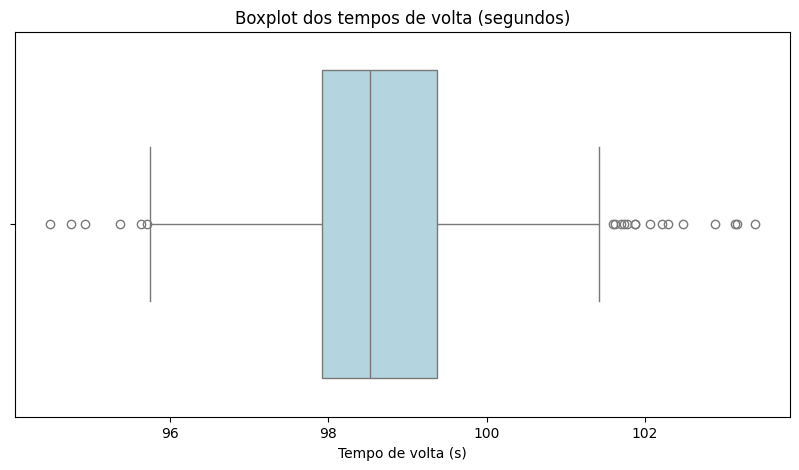

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['LapTimeSeconds'], color='lightblue')
plt.title('Boxplot dos tempos de volta (segundos)')
plt.xlabel('Tempo de volta (s)')
plt.show()


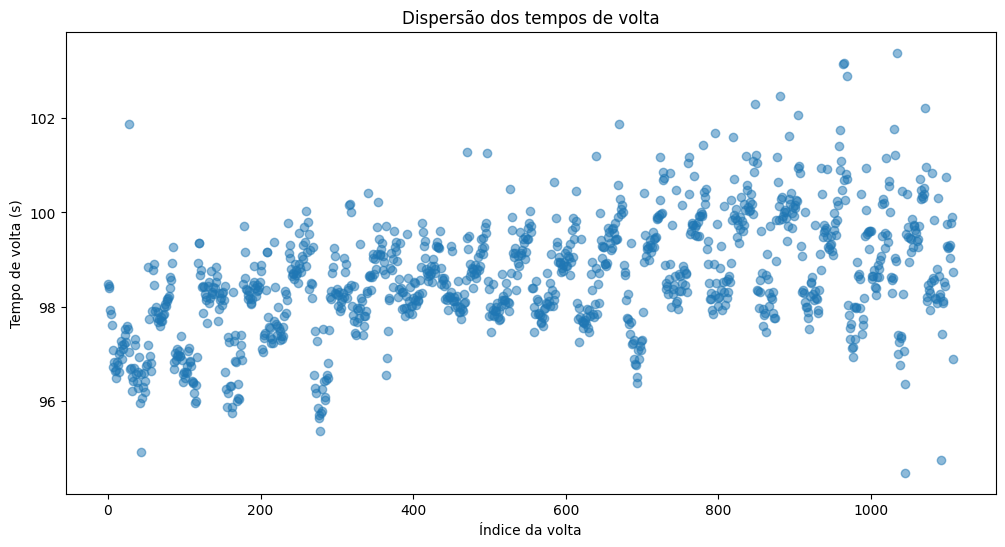

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df)), df['LapTimeSeconds'], alpha=0.5)
plt.title('Dispersão dos tempos de volta')
plt.xlabel('Índice da volta')
plt.ylabel('Tempo de volta (s)')
plt.show()


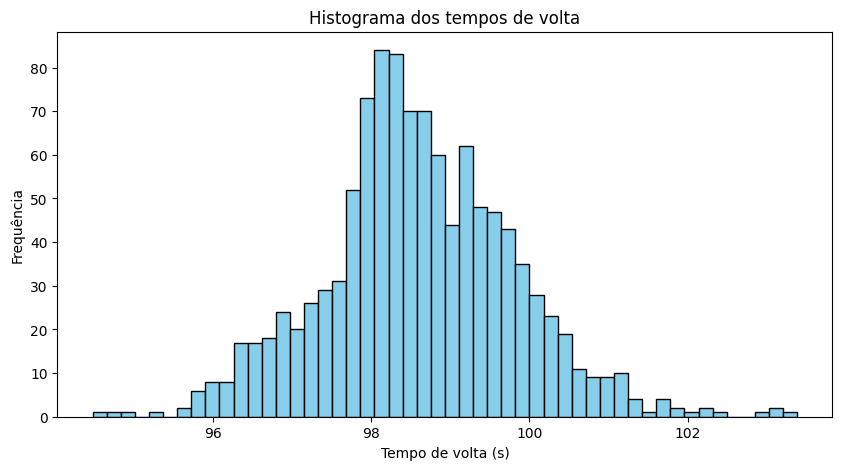

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(df['LapTimeSeconds'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma dos tempos de volta')
plt.xlabel('Tempo de volta (s)')
plt.ylabel('Frequência')
plt.show()


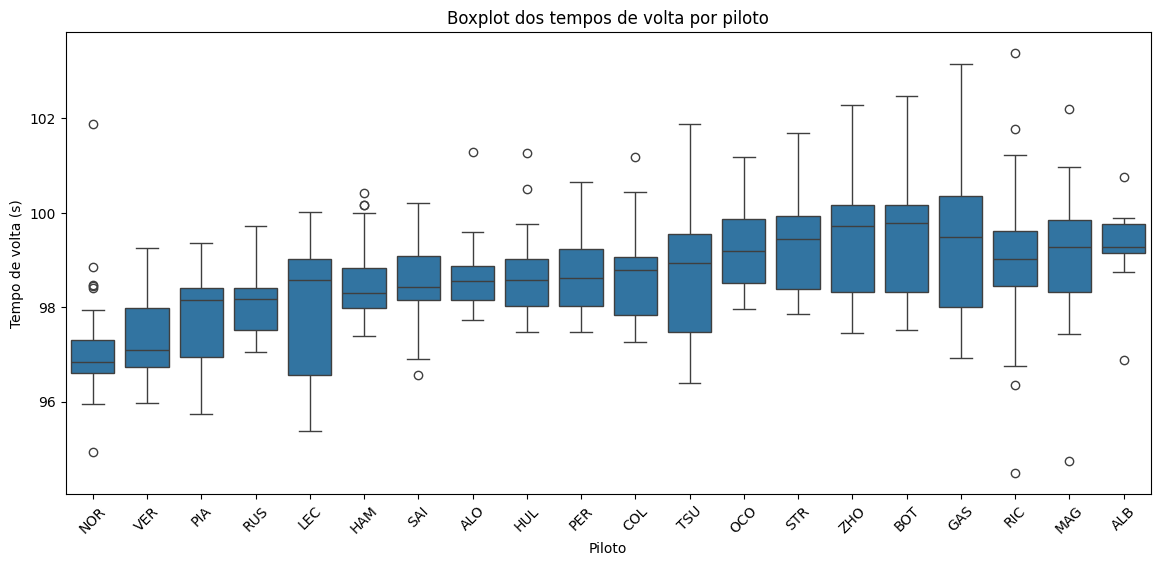

In [13]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Driver', y='LapTimeSeconds', data=df)
plt.title('Boxplot dos tempos de volta por piloto')
plt.xlabel('Piloto')
plt.ylabel('Tempo de volta (s)')
plt.xticks(rotation=45)
plt.show()


In [14]:
menor_volta_por_piloto = df.groupby('Driver')['LapTime'].min().sort_values()
print(menor_volta_por_piloto)


Driver
RIC   0 days 00:01:34.486000
MAG   0 days 00:01:34.754000
NOR   0 days 00:01:34.925000
LEC   0 days 00:01:35.371000
PIA   0 days 00:01:35.745000
VER   0 days 00:01:35.967000
TSU   0 days 00:01:36.393000
SAI   0 days 00:01:36.561000
ALB   0 days 00:01:36.888000
GAS   0 days 00:01:36.927000
RUS   0 days 00:01:37.047000
COL   0 days 00:01:37.262000
HAM   0 days 00:01:37.393000
ZHO   0 days 00:01:37.461000
HUL   0 days 00:01:37.470000
PER   0 days 00:01:37.477000
BOT   0 days 00:01:37.524000
ALO   0 days 00:01:37.741000
STR   0 days 00:01:37.851000
OCO   0 days 00:01:37.964000
Name: LapTime, dtype: timedelta64[ns]


In [15]:
year = 2024
grand_prix = 'Cingapura'
race_date = '2024-09-22'  # ex: usar o dado do evento ou da sessão

# Calcular métricas por piloto (como antes)
consistency_df = df.groupby('Driver')['LapTimeSeconds'].agg([
    'count',
    'mean',
    'std',
    'min',
    'max',
    'median'
]).rename(columns={
    'count': 'NumVoltas',
    'mean': 'MediaTempo',
    'std': 'DesvioPadrao',
    'min': 'MelhorVolta',
    'max': 'PiorVolta',
    'median': 'MedianaTempo'
})

consistency_df['RangeTempo'] = consistency_df['PiorVolta'] - consistency_df['MelhorVolta']

# Adicionar colunas fixas
consistency_df['Year'] = year
consistency_df['GrandPrix'] = grand_prix
consistency_df['RaceDate'] = race_date

# Resetar índice para 'Driver' virar coluna normal
consistency_df = consistency_df.reset_index()


In [16]:
consistency_df

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate
0,ALB,11,99.269273,0.953006,96.888,100.750,99.2850,3.862,2024,Cingapura,2024-09-22
1,ALO,58,98.614914,0.605847,97.741,101.282,98.5520,3.541,2024,Cingapura,2024-09-22
2,BOT,58,99.462500,1.169541,97.524,102.474,99.7920,4.950,2024,Cingapura,2024-09-22
3,COL,58,98.641914,0.824907,97.262,101.189,98.7895,3.927,2024,Cingapura,2024-09-22
4,GAS,58,99.409328,1.499919,96.927,103.156,99.4895,6.229,2024,Cingapura,2024-09-22
5,HAM,59,98.466898,0.688579,97.393,100.411,98.3090,3.018,2024,Cingapura,2024-09-22
6,HUL,58,98.617190,0.730888,97.470,101.269,98.5765,3.799,2024,Cingapura,2024-09-22
7,LEC,59,98.028119,1.343776,95.371,100.029,98.5820,4.658,2024,Cingapura,2024-09-22
8,MAG,51,99.179588,1.181066,94.754,102.209,99.2740,7.455,2024,Cingapura,2024-09-22
9,NOR,59,97.062136,0.928244,94.925,101.878,96.8320,6.953,2024,Cingapura,2024-09-22


In [17]:
# Juntar os dois DataFrames pela coluna 'Driver'
df_final = consistency_df.merge(df_features, on='Driver', how='inner')


In [18]:
df_final

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu
0,ALB,11,99.269273,0.953006,96.888,100.750,99.2850,3.862,2024,Cingapura,2024-09-22,15.0,False
1,ALO,58,98.614914,0.605847,97.741,101.282,98.5520,3.541,2024,Cingapura,2024-09-22,61.0,True
2,BOT,58,99.462500,1.169541,97.524,102.474,99.7920,4.950,2024,Cingapura,2024-09-22,61.0,True
3,COL,58,98.641914,0.824907,97.262,101.189,98.7895,3.927,2024,Cingapura,2024-09-22,61.0,True
4,GAS,58,99.409328,1.499919,96.927,103.156,99.4895,6.229,2024,Cingapura,2024-09-22,61.0,True
5,HAM,59,98.466898,0.688579,97.393,100.411,98.3090,3.018,2024,Cingapura,2024-09-22,62.0,True
6,HUL,58,98.617190,0.730888,97.470,101.269,98.5765,3.799,2024,Cingapura,2024-09-22,61.0,True
7,LEC,59,98.028119,1.343776,95.371,100.029,98.5820,4.658,2024,Cingapura,2024-09-22,62.0,True
8,MAG,51,99.179588,1.181066,94.754,102.209,99.2740,7.455,2024,Cingapura,2024-09-22,57.0,True
9,NOR,59,97.062136,0.928244,94.925,101.878,96.8320,6.953,2024,Cingapura,2024-09-22,62.0,True


In [19]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,1,12.0,7.50,0.000000,0.733333,0.266667
1,ALO,1,26.0,30.50,0.000000,0.409836,0.590164
2,BOT,1,34.0,30.50,0.000000,0.459016,0.540984
3,COL,1,30.0,30.50,0.000000,0.475410,0.524590
4,GAS,1,38.0,30.50,0.393443,0.606557,0.000000
5,HAM,1,18.0,31.00,0.274194,0.000000,0.725806
6,HUL,1,30.0,30.50,0.000000,0.475410,0.524590
7,LEC,1,37.0,31.00,0.000000,0.580645,0.419355
8,MAG,2,29.0,19.00,0.140351,0.368421,0.491228
9,NOR,1,31.0,31.00,0.000000,0.483871,0.516129


In [20]:
df_completo = df_final.merge(df_pit_features, on='Driver', how='inner')


In [21]:
df_completo

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,11,99.269273,0.953006,96.888,100.750,99.2850,3.862,2024,Cingapura,2024-09-22,15.0,False,1,12.0,7.50,0.000000,0.733333,0.266667
1,ALO,58,98.614914,0.605847,97.741,101.282,98.5520,3.541,2024,Cingapura,2024-09-22,61.0,True,1,26.0,30.50,0.000000,0.409836,0.590164
2,BOT,58,99.462500,1.169541,97.524,102.474,99.7920,4.950,2024,Cingapura,2024-09-22,61.0,True,1,34.0,30.50,0.000000,0.459016,0.540984
3,COL,58,98.641914,0.824907,97.262,101.189,98.7895,3.927,2024,Cingapura,2024-09-22,61.0,True,1,30.0,30.50,0.000000,0.475410,0.524590
4,GAS,58,99.409328,1.499919,96.927,103.156,99.4895,6.229,2024,Cingapura,2024-09-22,61.0,True,1,38.0,30.50,0.393443,0.606557,0.000000
5,HAM,59,98.466898,0.688579,97.393,100.411,98.3090,3.018,2024,Cingapura,2024-09-22,62.0,True,1,18.0,31.00,0.274194,0.000000,0.725806
6,HUL,58,98.617190,0.730888,97.470,101.269,98.5765,3.799,2024,Cingapura,2024-09-22,61.0,True,1,30.0,30.50,0.000000,0.475410,0.524590
7,LEC,59,98.028119,1.343776,95.371,100.029,98.5820,4.658,2024,Cingapura,2024-09-22,62.0,True,1,37.0,31.00,0.000000,0.580645,0.419355
8,MAG,51,99.179588,1.181066,94.754,102.209,99.2740,7.455,2024,Cingapura,2024-09-22,57.0,True,2,29.0,19.00,0.140351,0.368421,0.491228
9,NOR,59,97.062136,0.928244,94.925,101.878,96.8320,6.953,2024,Cingapura,2024-09-22,62.0,True,1,31.0,31.00,0.000000,0.483871,0.516129


In [22]:
print("Shape final:", df_completo.shape)
print("Pilotos presentes:", df_completo['Driver'].nunique())


Shape final: (20, 19)
Pilotos presentes: 20


In [23]:
df_completo.to_csv('df_completoCingapura.csv', index=False)
